In [1]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *

# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum")

# Invoke a primitive. For more details see https://qiskit.org/documentation/partners/qiskit_ibm_runtime/tutorials.html
# result = Sampler("ibmq_qasm_simulator").run(circuits).result()

configrc.store_credentials:WARNING:2023-07-13 17:13:31,763: Credentials already present. Set overwrite=True to overwrite.
ibmqfactory.load_account:WARNING:2023-07-13 17:13:31,842: Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run
{'001': 118, '101': 132, '000': 114, '011': 124, '111': 123, '010': 127, '100': 142, '110': 120}


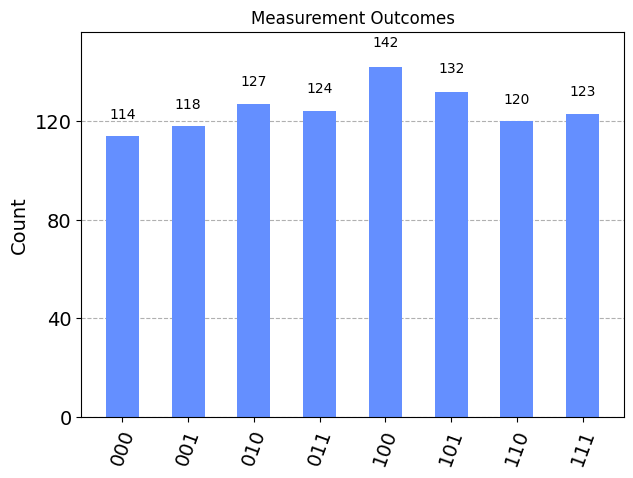

In [3]:
import numpy as np
from qiskit import QuantumCircuit, transpile, assemble, IBMQ, execute
from qiskit.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor


def initialize_state(qc, qubits):
    qc.h(qubits)  # Apply Hadamard gate to all qubits
    qc.z(qubits)  # Apply Z gate to all qubits

def oracle(qc, qubits, marked_item):
    qc.barrier()
    marked_item = marked_item[::-1]  # Reverse the order of the marked item
    for i in range(len(marked_item)):
        if marked_item[i] == '1':
            qc.cx(qubits[i], qubits[-1])  # Apply CNOT gate if marked bit is 1
    qc.barrier()

def diffusion(qc, qubits):
    qc.h(qubits[:-1])  # Apply Hadamard gate to all qubits except the last one
    qc.x(qubits[:-1])  # Apply X gate to all qubits except the last one
    qc.h(qubits[-2])   # Apply Hadamard gate to the second-to-last qubit
    qc.cx(qubits[0], qubits[-2])  # Apply CNOT gate with control on the first qubit and target on the second-to-last qubit
    qc.h(qubits[-2])   # Apply Hadamard gate to the second-to-last qubit
    qc.x(qubits[:-1])  # Apply X gate to all qubits except the last one
    qc.h(qubits[:-1])  # Apply Hadamard gate to all qubits except the last one

def grovers_search(num_iterations, marked_item):
    num_qubits = len(marked_item)
    qubits = range(num_qubits + 1)
    qc = QuantumCircuit(num_qubits + 1, num_qubits)
    initialize_state(qc, qubits)
    for _ in range(num_iterations):
        oracle(qc, qubits, marked_item)
        diffusion(qc, qubits)
    qc.measure(qubits[:-1], range(num_qubits))

    provider = IBMQ.get_provider(hub='ibm-q')
    backend = provider.get_backend('ibmq_qasm_simulator')
    transpiled_circuit = transpile(qc, backend)
    qobj = assemble(transpiled_circuit, shots=1000)

    job = backend.run(qobj)
    job_monitor(job)

    result = job.result()
    counts = result.get_counts(qc)

    return counts

# Load your IBM Quantum account
IBMQ.save_account('65623006e3ded7f0ffb828ecf50170dadb7583d4a0e458803a0471339c49019b1ad12d5d1794c8ff59543ef4db55583f12226f5c9951f2129f77096895a335e7')
IBMQ.load_account()

# Example usage
marked_item = '011'  # Item to be marked as '1' in the database
num_iterations = 2  # Replace with the desired number of iterations

counts = grovers_search(num_iterations, marked_item)

# Visualize the measurement results
plot = plot_histogram(counts, title="Measurement Outcomes")

# Save the plot as an image file
plot.savefig("histogram.png")

# Print the measurement results
print(counts)

plot_histogram(counts, title="Measurement Outcomes")
